# Identifying successful interventions (practices) in opioid prescribing data

This notebook contains methodology and results of an analysis of opioid prescribing data. The practices with the ten largest reductions in opioid prescribing are shown here, but it is also possible to access the most recent (last five years) results for any practice or CCG via the [OpenPrescribing.net](OpenPrescribing.net) website.

To find an organisation’s data for any of the three opioid measures use in this analysis, navigate to the specific measure’s landing page. For the measures described in this notebook, these are:

- [Total oral morphine equivalence](https://openprescribing.net/measure/opioidome/)
- [High dose opioids as percentage regular opioids](https://openprescribing.net/measure/opioidspercent/)
- [High dose opioids per 1000 patients](https://openprescribing.net/measure/opioidper1000/)

Decile plots for all current CCGs are available on the measure landing page; specific CCGs can be identified via a text search in your browser. To view similar decile plots for a practice, click the “Split the measure into chargers for individual practice” link under the parent CCG.

Alternatively, summary results can be obtained for more than one organisation at once by selecting “View this measure on the analyse page” (under “Explore”) on the measure’s landing page (10–12); this will launch a new analysis, pre-loaded with the relevant drugs or BNF sections. Any number of organisations (CCGs or practices) can then be selected by typing code or text into the “highlighting” box; clicking on the “Show me the data!” button will launch this analysis and display the results as a histogram, time series or as a choropleth map. All plots and raw data are available for download.

## Import libraries required for analysis

In [1]:
# NBVAL_IGNORE_OUTPUT
# ^this is a magic comment to work around this issue https://github.com/ebmdatalab/custom-docker/issues/10
from change_detection import functions as chg
from ebmdatalab import bq
from lib.outliers import *  #This is copied into the local folder from a branch ebmdatalab pandas library - it will be placed in its own repo to install at a later dat
import numpy as np

## Run change detection for the 3 OpenPrescribing opioid measures
- looks for changes in time-series data
- as described in https://www.bmj.com/content/367/bmj.l5205

In [2]:
# NBVAL_IGNORE_OUTPUT
# ^this is a magic comment to work around this issue https://github.com/ebmdatalab/custom-docker/issues/10
opioids_class = chg.ChangeDetection('practice_data_opioid%',
                                    measure=True,
                                    direction='down',
                                    overwrite=False,
                                    verbose=False,
                                    draw_figures='no')
opioids_class.run()

Using cached data


## Import results of change detection

In [3]:
opioids = opioids_class.concatenate_outputs()
opioids.head()

is.nbreak  is.tfirst  is.tfirst.pknown  \
measure                 name                                             
practice_data_opioidome A81001  0         NaN        NaN                 
                        A81002  0         NaN        NaN                 
                        A81004  0         NaN        NaN                 
                        A81005  0         NaN        NaN                 
                        A81006  1          inf        inf                

                                is.tfirst.pknown.offs  is.tfirst.offs  \
measure                 name                                            
practice_data_opioidome A81001 NaN                    NaN               
                        A81002 NaN                    NaN               
                        A81004 NaN                    NaN               
                        A81005 NaN                    NaN               
                        A81006  inf                    inf              

                                is.tfirst.big  is.slope.ma  is.slope.ma.prop  \
measure                 name                                                   
practice_data_opioidome A81001 NaN            NaN          NaN                 
                        A81002 NaN            NaN          NaN                 
                        A81004 NaN            NaN          NaN                 
                        A81005 NaN            NaN          NaN                 
                        A81006 NaN            NaN          NaN                 

                                is.slope.ma.prop.lev  is.intlev.initlev  \
measure                 name                                              
practice_data_opioidome A81001 NaN                   NaN                  
                        A81002 NaN                   NaN                  
                        A81004 NaN                   NaN                  
                        A81005 NaN                   NaN                  
                        A81006 NaN                   NaN                  

                                is.intlev.finallev  is.intlev.levd  \
measure                 name                                         
practice_data_opioidome A81001 NaN                 NaN               
                        A81002 NaN                 NaN               
                        A81004 NaN                 NaN               
                        A81005 NaN                 NaN               
                        A81006  50330.014139       NaN               

                                is.intlev.levdprop  
measure                 name                        
practice_data_opioidome A81001 NaN                  
                        A81002 NaN                  
                        A81004 NaN                  
                        A81005 NaN                  
                        A81006 NaN

### Get list to filter out closed practices

In [4]:
query = """
SELECT
  DISTINCT code
FROM
  ebmdatalab.hscic.practices
WHERE
  status_code = "A"
"""
open_practices = bq.cached_read(query,csv_path='data/open_practices.csv')
open_practices.head()

,code
0,W94609
1,W94622
2,W95036
3,A99915
4,A99960


### Get practices with a small list size to filter them out 

In [5]:
query = """
SELECT
  DISTINCT practice
FROM
  ebmdatalab.hscic.practice_statistics
WHERE
  total_list_size < 2000
"""
small_list_size = bq.cached_read(query,csv_path='data/small_list_size.csv')
small_list_size.head()

,practice
0,Y00031
1,Y00613
2,Y02313
3,Y02797
4,Y02926


### Remove small list sizes and closed/dormant practices

In [6]:
print(len(opioids))
mask = opioids.index.get_level_values(1).isin(open_practices['code'])
opioids = opioids.loc[mask]
print(len(opioids))
mask = opioids.index.get_level_values(1).isin(small_list_size['practice'])
opioids = opioids.loc[~mask]
print(len(opioids))
opioids.head()

36856
33581
32484


is.nbreak  is.tfirst  is.tfirst.pknown  \
measure                 name                                             
practice_data_opioidome A81001  0         NaN        NaN                 
                        A81002  0         NaN        NaN                 
                        A81004  0         NaN        NaN                 
                        A81005  0         NaN        NaN                 
                        A81006  1          inf        inf                

                                is.tfirst.pknown.offs  is.tfirst.offs  \
measure                 name                                            
practice_data_opioidome A81001 NaN                    NaN               
                        A81002 NaN                    NaN               
                        A81004 NaN                    NaN               
                        A81005 NaN                    NaN               
                        A81006  inf                    inf              

                                is.tfirst.big  is.slope.ma  is.slope.ma.prop  \
measure                 name                                                   
practice_data_opioidome A81001 NaN            NaN          NaN                 
                        A81002 NaN            NaN          NaN                 
                        A81004 NaN            NaN          NaN                 
                        A81005 NaN            NaN          NaN                 
                        A81006 NaN            NaN          NaN                 

                                is.slope.ma.prop.lev  is.intlev.initlev  \
measure                 name                                              
practice_data_opioidome A81001 NaN                   NaN                  
                        A81002 NaN                   NaN                  
                        A81004 NaN                   NaN                  
                        A81005 NaN                   NaN                  
                        A81006 NaN                   NaN                  

                                is.intlev.finallev  is.intlev.levd  \
measure                 name                                         
practice_data_opioidome A81001 NaN                 NaN               
                        A81002 NaN                 NaN               
                        A81004 NaN                 NaN               
                        A81005 NaN                 NaN               
                        A81006  50330.014139       NaN               

                                is.intlev.levdprop  
measure                 name                        
practice_data_opioidome A81001 NaN                  
                        A81002 NaN                  
                        A81004 NaN                  
                        A81005 NaN                  
                        A81006 NaN

# Results
These are filtered:
- to only include practices that started within the highest 20% of all practices
- to remove any practices that have a short sudden spike that would lead the change detection algorithm to detect a sudden drop

and then sorted according to the largest total measured drop.

## Total Oral Morphine Equivalence
https://openprescribing.net/measure/opioidome

In [7]:
OME_table, all_OME_changes = filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidome',
                   'practice_data_opioidome')

/home/app/notebook/lib/outliers.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_changes['min_month'] = data['month'].min()
/home/app/notebook/lib/outliers.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_changes['is.tfirst.big'] = all_changes.apply(lambda x:


,Month when change detected,Measured proportional change,plots
link,,,
VALENTINE MEDICAL CENTRE,2018-06-01,0.736706,
MP VICTORIA MILL,2018-09-01,0.619678,
WESTERN AVE MEDICAL CTRE,2017-02-01,0.610835,
THE WEAVERHAM SURGERY,2017-09-01,0.591525,
3/SPRINGFIELD HOUSE MEDICAL PRACTICE,2016-12-01,0.561731,
PADDOCK AND LONGWOOD FAMILY PRACTICE,2017-05-01,0.545953,
WEST HEATH SURGERY,2015-11-01,0.536242,
QUEEN STREET SURGERY,2017-08-01,0.525459,
SHAFTESBURY MEDICAL CTR.,2017-08-01,0.521498,

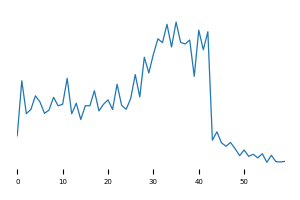
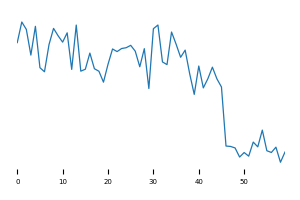
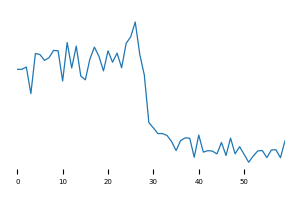
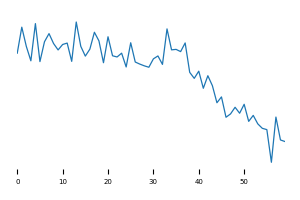
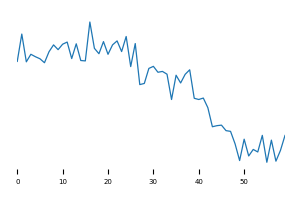
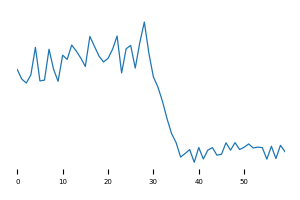
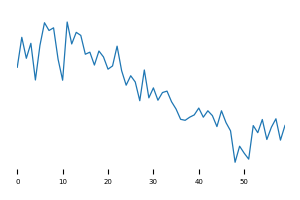
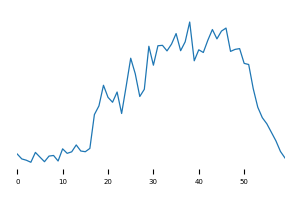
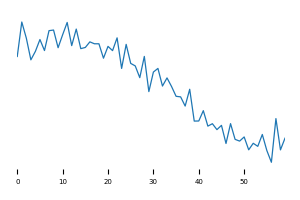
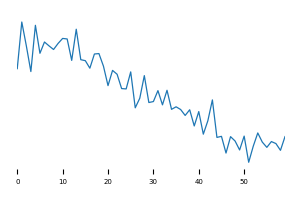

In [8]:
display( OME_table )

## High dose opioids as percentage regular opioids

https://openprescribing.net/measure/opioidspercent

In [9]:
highperc_table, all_highperc_changes = filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidspercent',
                   'practice_data_opioidspercent')

,Month when change detected,Measured proportional change,plots
link,,,
DE BEAUVOIR SURGERY,2018-08-01,0.998944,
THE PINNER ROAD SURGERY,2017-05-01,0.997335,
PERIVALE MEDICAL CLINIC,2016-03-01,0.995019,
EARLS COURT MEDICAL CENTRE,2018-08-01,0.990121,
THE VILLAGE MEDICAL CTR,2016-08-01,0.976802,
CRANESWATER GROUP PRACTICE,2018-03-01,0.971633,
KIMBOLTON MEDICAL CENTRE,2018-01-01,0.962556,
HORNSEY PARK SURGERY,2015-06-01,0.911455,
BOWBURN MEDICAL CENTRE,2016-04-01,0.888492,

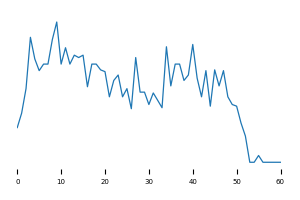
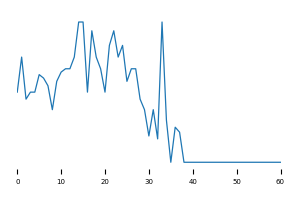
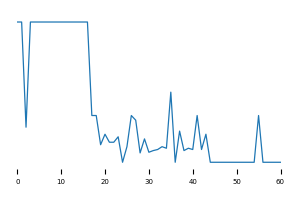
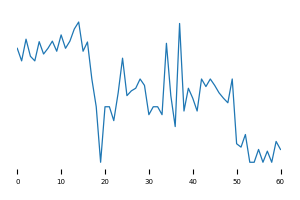
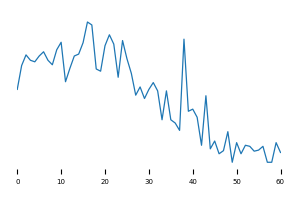
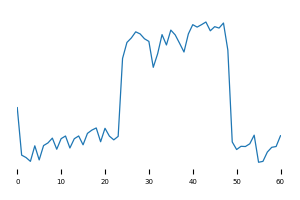
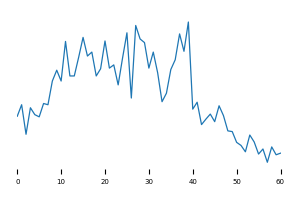
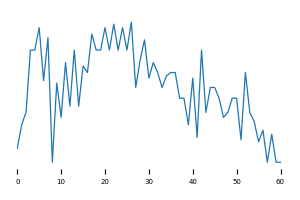
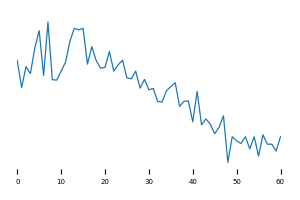
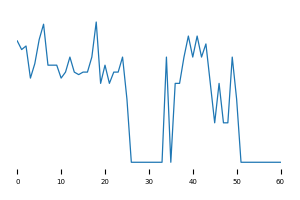

In [10]:
display( highperc_table )

## High dose opioids per 1000 patients

https://openprescribing.net/measure/opioidper1000

In [11]:
high1000_table, all_high1000_changes = filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidper1000',
                   'practice_data_opioidper1000')

,Month when change detected,Measured proportional change,plots
link,,,
CRANESWATER GROUP PRACTICE,2017-08-01,0.972216,
WILLENHAL OAK MEDICAL CENTRE,2018-02-01,0.968600,
3/SPRINGFIELD HOUSE MEDICAL PRACTICE,2018-02-01,0.951970,
QUEEN STREET SURGERY,2018-08-01,0.932033,
HOPWOOD MEDICAL CENTRE,2018-09-01,0.925599,
DR VARDHAN'S SURGERY,2017-06-01,0.905956,
HUNTLEY MOUNT MEDICAL CENTRE,2017-07-01,0.890936,
CRAMLINGTON MEDICAL GROUP,2017-01-01,0.890191,
PENNINGTON PARK SURGERY,2017-11-01,0.884191,

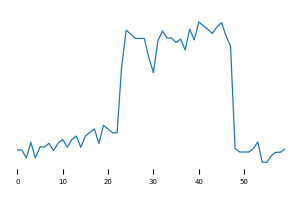
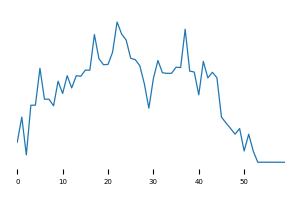
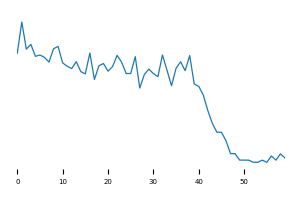
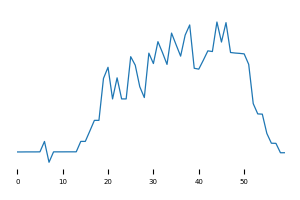
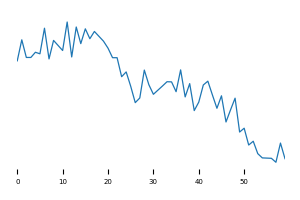
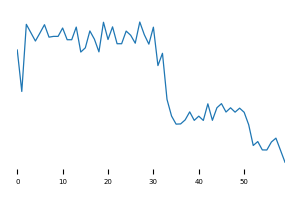
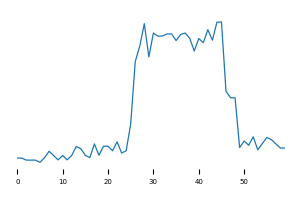
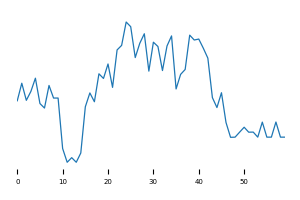
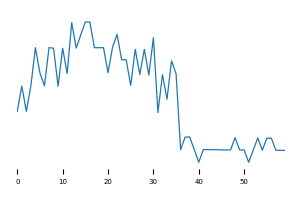
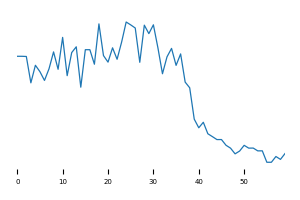

In [12]:
display( high1000_table )

## Summary statistics

Summary statistics shown for all practices demonstrating a decrease.

In [13]:
all_OME_changes["measure"] = "Total oral morphine equivalence"
all_highperc_changes["measure"] = "High dose opioids as percentage regular opioids"
all_high1000_changes["measure"] = "High dose opioids per 1000 patients"

all_changes = all_OME_changes.append(all_highperc_changes).append(all_high1000_changes)
all_changes = all_changes[~all_changes.isin([np.nan, np.inf, -np.inf]).any(1)]
all_decreases = all_changes[all_changes['is.intlev.levdprop']>0]

practice_decreases_summary = all_decreases.groupby("measure")["is.intlev.levdprop"].describe()
practice_decreases_summary['IQR'] = practice_decreases_summary['75%'] - practice_decreases_summary['25%']
practice_decreases_summary.rename( columns={'50%' : 'median'}, inplace=True)

practice_decreases_summary_tosave = practice_decreases_summary[['count', 'median','IQR','min', 'max']]
practice_decreases_summary_tosave['median'] = (100 * practice_decreases_summary_tosave['median']).round(1)
practice_decreases_summary_tosave['IQR'] = (100 * practice_decreases_summary_tosave['IQR']).round(1)
practice_decreases_summary_tosave['min'] = (100 * practice_decreases_summary_tosave['min']).round(1)
practice_decreases_summary_tosave['max'] = (100 * practice_decreases_summary_tosave['max']).round(1)

display( practice_decreases_summary_tosave )

<ipython-input-13-7c760b22752c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  practice_decreases_summary_tosave['median'] = (100 * practice_decreases_summary_tosave['median']).round(1)
<ipython-input-13-7c760b22752c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  practice_decreases_summary_tosave['IQR'] = (100 * practice_decreases_summary_tosave['IQR']).round(1)
<ipython-input-13-7c760b22752c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,count,median,IQR,min,max
measure,,,,,
High dose opioids as percentage regular opioids,4632.0,47.7,32.9,0.0,100.0
High dose opioids per 1000 patients,4334.0,56.0,35.7,0.0,100.0
Total oral morphine equivalence,4100.0,28.2,19.8,0.1,99.1
